In [102]:
from tqdm import tqdm
import os
import time
from datetime import datetime
from random import randint

import numpy as np
from scipy import stats
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import KFold

import nibabel as nib

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as anim
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

import seaborn as sns
from skimage.transform import resize
from skimage.util import montage

from IPython.display import Image as show_gif
from IPython.display import clear_output

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

import re
import warnings


warnings.simplefilter("ignore")


In [103]:
from utils.Meter import Meter, DiceLoss, BCEDiceLoss, dice_coef_metric_per_classes, jaccard_coef_metric_per_classes

# CAN POTENTIALLY TRY DIFFERENT AUGMENTATION TECHNIQUES HERE
from utils.BratsDataset import BratsDataset

from utils.Meter import BCEDiceLoss

from models.UNet3d import UNet3d
from models.UNet3dDropout import UNet3dDropout
from models.SwinUNETR import SwinUNETR
from models.UNet3d_your_modifications import UNet3d_your_modifications
from models.UNet3d_SELU import UNet3d_SELU
from models.UNet3d_atten import UNet3d_atten
from models.ONet3d import ONet3d
from models.ONet3d_v2 import ONet3d_v2
from models.ONet3d_v3 import ONet3d_v3
from models.ONet3d_v3_DoubleConv import ONet3d_v3_DoubleConv
from models.UNet3d_GELU import UNet3d_GELU
from models.ONet3d_v3_GELU import ONet3d_v3_GELU
from models.SphereNet3d import SphereNet3d
# from models.SphereNet3d_GELU import SphereNet3d_GELU


In [104]:
def get_losses(filename):

  # open the text file
  with open(filename, 'r') as f:
      contents = f.read()

  # extract the train losses and val losses using regular expressions
  train_losses_str = re.search(r"losses:{'train': (.+?), 'val'", contents).group(1)
  val_losses_str = re.search(r"'val': \[(.+?)\}", contents).group(1)

  train_losses_str = train_losses_str.replace('[', '').replace(']', '')
  val_losses_str = val_losses_str.replace('[', '').replace(']', '')

  # convert the strings to lists of floating-point numbers
  train_losses = [float(x.strip()) for x in train_losses_str.split(', ')]
  val_losses = [float(x.strip()) for x in val_losses_str.split(', ')]
  
  print(f"{len(train_losses)} train and {len(val_losses)} val losses found in {filename}")

  # print the lists
  return train_losses, val_losses





def get_param_count(filename):

  # open the text file
  with open(filename, 'r') as f:
      contents = f.read()

  # extract the param count using regular expressions
  param_str = re.search(
      r"(?<=parameter_count:).*", contents).group(0)
  param_count = int(param_str)
  print(f"Parameter count = {param_count} in {filename}")
  
  return param_count


def get_dice_scores(filename):

  # open the text file
  with open(filename, 'r') as f:
      lines = f.readlines()
      
  for line in lines:
    if "dice_scores" in line:

    # extract the dice scores and iou scores using regular expressions
      train_dice_str = re.search(
          r"'train': (.+?), 'val'", line).group(1)
      val_dice_str = re.search(r"'val': \[(.+?)\}", line).group(1)

      train_dice_str = train_dice_str.replace('[', '').replace(']', '')
      val_dice_str = val_dice_str.replace('[', '').replace(']', '')

      # convert the strings to lists of floating-point numbers
      train_dice = [float(x.strip()) for x in train_dice_str.split(', ')]
      val_dice = [float(x.strip()) for x in val_dice_str.split(', ')]
      break
  print(f"{len(train_dice)} train and {len(val_dice)} val dice score found in {filename}")
  return train_dice, val_dice


def get_jaccard_scores(filename):

  # open the text file
  with open(filename, 'r') as f:
      lines = f.readlines()

  for line in lines:
    if "jaccard_scores" in line:

      # extract the dice scores and iou scores using regular expressions
      train_jaccard_str = re.search(
          r"'train': (.+?), 'val'", line).group(1)
      val_jaccard_str = re.search(r"'val': \[(.+?)\}", line).group(1)

      train_jaccard_str = train_jaccard_str.replace('[', '').replace(']', '')
      val_jaccard_str = val_jaccard_str.replace('[', '').replace(']', '')

      # convert the strings to lists of floating-point numbers
      train_jaccard = [float(x.strip()) for x in train_jaccard_str.split(', ')]
      val_jaccard = [float(x.strip()) for x in val_jaccard_str.split(', ')]
      break
  print(f"{len(train_jaccard)} train and {len(val_jaccard)} val jaccard score found in {filename}")
  return train_jaccard, val_jaccard

def get_train_run_time(filename):

  # open the text file
  with open(filename, 'r') as f:
      contents = f.read()

  # extract the param count using regular expressions
  time_str = re.search(
      r"(?<=last_completed_run_time:).*(?=\n)", contents).group(0)
  time_obj = datetime.strptime(time_str, "%H:%M:%S.%f").time()
  print(f"Trainer runtime = {time_obj} in {filename}")
  return time_obj

FILENAME = "Logs/3DOnet_DoubleConv_Kernel1/trainer_properties.txt"

get_param_count(FILENAME)
get_train_run_time(FILENAME)
get_losses(FILENAME)
get_dice_scores(FILENAME)
get_jaccard_scores(FILENAME)
print("Test done")


Parameter count = 5896515 in Logs/3DOnet_DoubleConv_Kernel1/trainer_properties.txt
Trainer runtime = 05:51:38.640594 in Logs/3DOnet_DoubleConv_Kernel1/trainer_properties.txt
50 train and 50 val losses found in Logs/3DOnet_DoubleConv_Kernel1/trainer_properties.txt
50 train and 50 val dice score found in Logs/3DOnet_DoubleConv_Kernel1/trainer_properties.txt
50 train and 50 val jaccard score found in Logs/3DOnet_DoubleConv_Kernel1/trainer_properties.txt
Test done


In [105]:
results_dict = {}

for dirname in os.listdir("Logs"):
  model_name = dirname
  results_dict[model_name] = {}
  
  filename = f"Logs/{dirname}/trainer_properties.txt"
  parameter_count = get_param_count(filename)
  trainer_runtime = get_train_run_time(filename)
  train_losses, val_losses = get_losses(filename)
  train_dices, val_dices = get_dice_scores(filename)
  train_jaccards, val_jacards = get_jaccard_scores(filename)
  results_dict[model_name]["parameter_count"] = parameter_count
  results_dict[model_name]["trainer_runtime"] = trainer_runtime
  results_dict[model_name]["train_losses"] = train_losses
  results_dict[model_name]["val_losses"] = val_losses
  results_dict[model_name]["train_dices"] = train_dices
  results_dict[model_name]["val_dices"] = val_dices
  results_dict[model_name]["train_jaccards"] = train_jaccards
  results_dict[model_name]["val_jacards"] = val_jacards
  


Parameter count = 5597571 in Logs/3DOnet_SingleConv_Kernel1_32_Channels/trainer_properties.txt
Trainer runtime = 12:10:09.814454 in Logs/3DOnet_SingleConv_Kernel1_32_Channels/trainer_properties.txt
50 train and 50 val losses found in Logs/3DOnet_SingleConv_Kernel1_32_Channels/trainer_properties.txt
50 train and 50 val dice score found in Logs/3DOnet_SingleConv_Kernel1_32_Channels/trainer_properties.txt
50 train and 50 val jaccard score found in Logs/3DOnet_SingleConv_Kernel1_32_Channels/trainer_properties.txt
Parameter count = 6134019 in Logs/SphereNet3D/trainer_properties.txt
Trainer runtime = 10:27:29.978756 in Logs/SphereNet3D/trainer_properties.txt
50 train and 50 val losses found in Logs/SphereNet3D/trainer_properties.txt
50 train and 50 val dice score found in Logs/SphereNet3D/trainer_properties.txt
50 train and 50 val jaccard score found in Logs/SphereNet3D/trainer_properties.txt
Parameter count = 3150435 in Logs/3DOnet_SingleConv_Kernel1_GELU_AdamW/trainer_properties.txt
Traine

In [106]:
for model_name in results_dict:
  print(results_dict[model_name])


{'parameter_count': 5597571, 'trainer_runtime': datetime.time(12, 10, 9, 814454), 'train_losses': [1.3054928562033765, 1.147444587696641, 1.0326140799449877, 0.9267138152068105, 0.8019969200453377, 0.656771807729518, 0.5074687702120937, 0.37521527809561883, 0.3046803882933388, 0.2684406184311602, 0.24207773308903546, 0.2183797525758979, 0.2034130649988189, 0.20374602442005288, 0.18574730539163256, 0.18823536491099419, 0.18568676180372673, 0.17106773228359767, 0.16804311321092197, 0.17239474618502895, 0.16611323852672777, 0.1669975903324301, 0.1584238620482017, 0.14875816019825608, 0.1476132988703115, 0.1506519480378229, 0.13883531959054587, 0.13295591420037212, 0.13068742171893102, 0.12965603861178734, 0.12879450386921262, 0.12732990182397938, 0.12720150557194373, 0.1266502524396766, 0.12616829300731308, 0.12502994028561015, 0.12353757420420193, 0.12330578985719626, 0.12325587456500575, 0.12315656852416212, 0.12304748838392048, 0.12297728482081409, 0.12270755058742294, 0.12270302841078

2023-03-20 09:27:05,518 - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


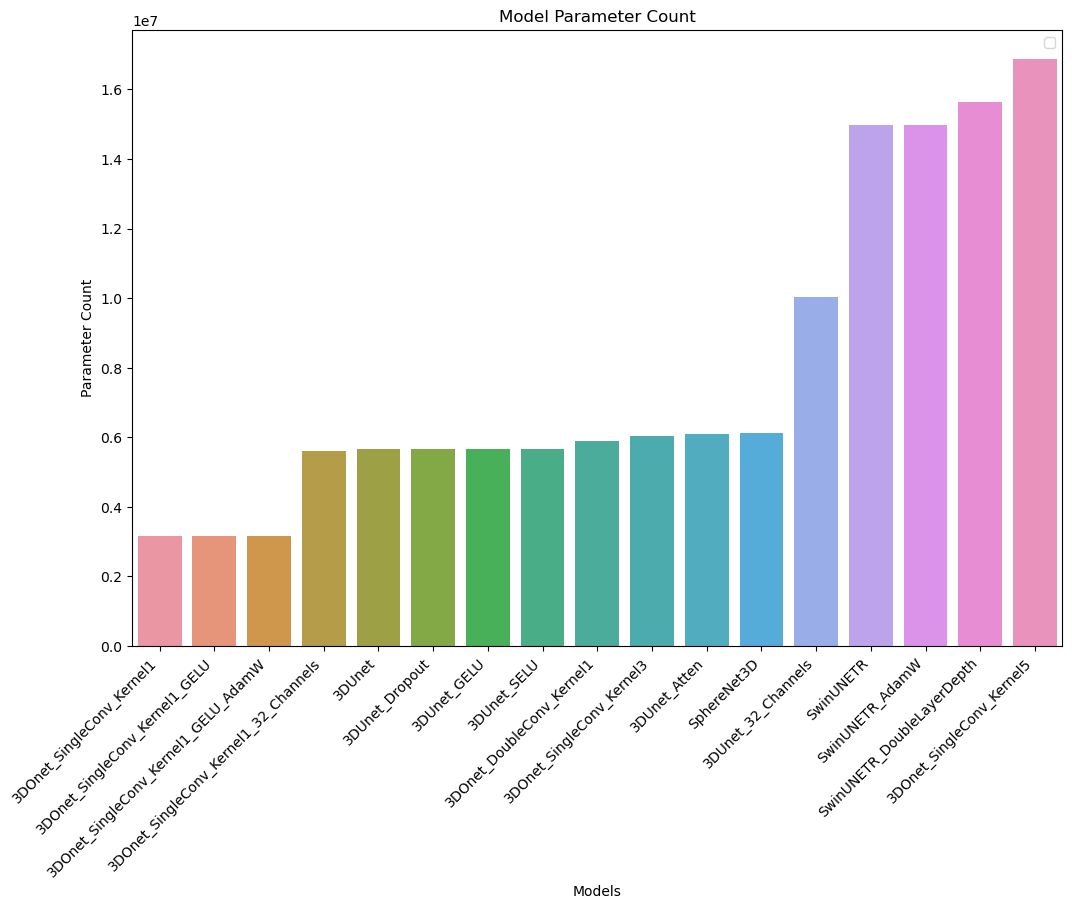

In [107]:
def plot_param_count(results_dict = results_dict):
  x = []
  y = []
  for model_name in results_dict:
    x.append(model_name)
    y.append(results_dict[model_name]["parameter_count"])
  
  # sort based on ascending order of parameter count
  x = [val for _, val in sorted(zip(y, x))]
  y = sorted(y)
  
  fig, ax = plt.subplots(figsize=(12, 8))
  ax.set_title("Model Parameter Count")
  sns.barplot(x=x, y=y)
  ax.set_xlabel("Models")
  ax.set_ylabel("Parameter Count")
  ax.legend()
  plt.xticks(rotation=45, ha='right')
  plt.show()


plot_param_count()

[datetime.time(3, 34, 44, 640158), datetime.time(3, 37, 32, 812110), datetime.time(3, 53, 35, 505063), datetime.time(4, 6, 28, 977779), datetime.time(4, 38, 10, 980250), datetime.time(5, 19, 13, 541999), datetime.time(5, 50, 58, 570332), datetime.time(5, 51, 38, 640594), datetime.time(6, 39, 10, 236862), datetime.time(6, 48, 20, 114492), datetime.time(7, 45, 28, 808567), datetime.time(10, 1, 18, 950033), datetime.time(10, 27, 29, 978756), datetime.time(10, 32, 40, 717688), datetime.time(12, 10, 9, 814454), datetime.time(14, 10, 39, 161235), datetime.time(15, 14, 58, 148519)]


TypeError: unsupported operand type(s) for +: 'int' and 'datetime.time'

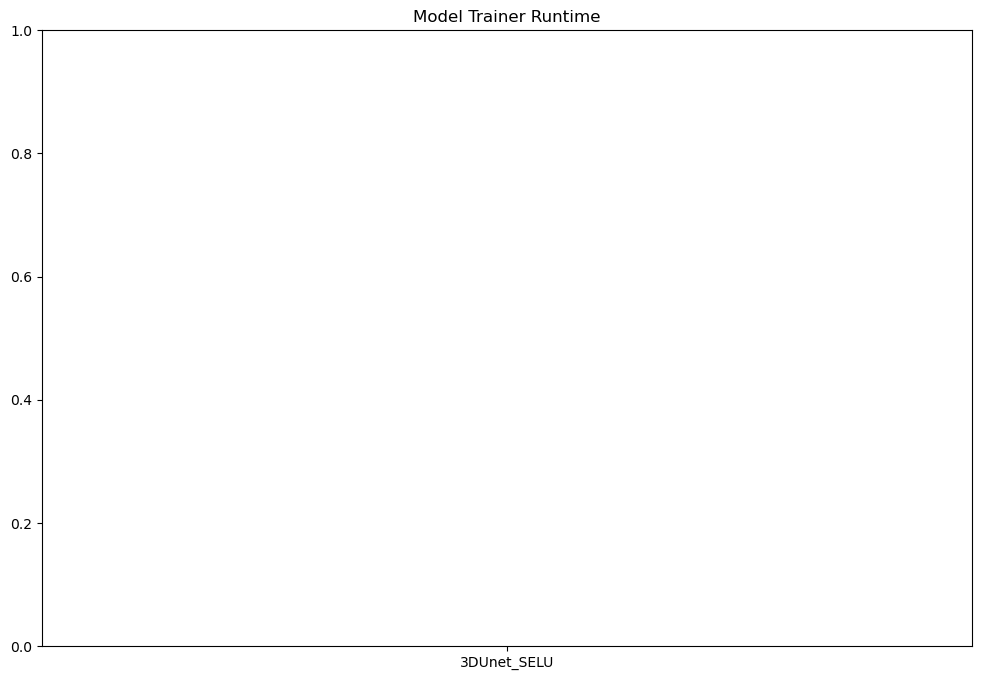

In [108]:
import matplotlib.dates as mdates
def plot_trainer_runtime(results_dict=results_dict):
  x = []
  y = []
  for model_name in results_dict:
    x.append(model_name)
    y.append(results_dict[model_name]["trainer_runtime"])

  # sort based on ascending order of parameter count
  x = [val for _, val in sorted(zip(y, x))]
  y = sorted(y)
  # today = datetime.datetime.now()
  # y = [datetime.datetime.combine(today, t) for t in y]
  print(y)
  fig, ax = plt.subplots(figsize=(12, 8))
  ax.set_title("Model Trainer Runtime")
  plt.bar(x, y)
  ax.set_xlabel("Models")
  ax.set_ylabel("Trainer Runtime")
  ax.legend()
  plt.xticks(rotation=45, ha='right')
  plt.show()


plot_trainer_runtime()


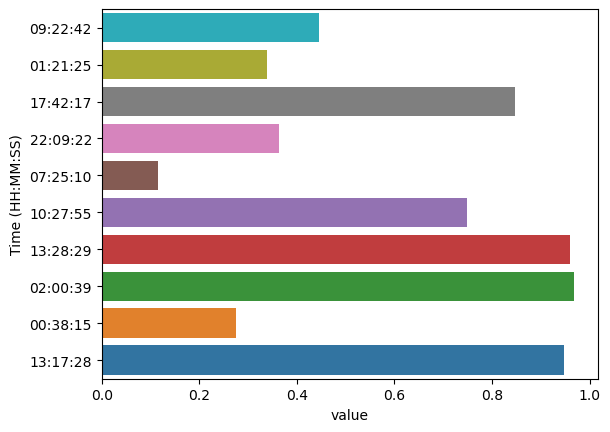

In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np
import datetime

# create sample data
times = [datetime.time(np.random.randint(0, 24), np.random.randint(
    0, 60), np.random.randint(0, 60)) for _ in range(10)]
values = np.random.rand(10)
df = pd.DataFrame({'time': times, 'value': values})

# plot bar chart
sns.barplot(x='value', y='time', data=df)

# format y-label
plt.gca().invert_yaxis()
plt.yticks(df.index, [t.strftime('%H:%M:%S') for t in df['time']])
plt.ylabel('Time (HH:MM:SS)')

# display plot
plt.show()
